# Prediction fo FRB/SP 

In [2]:
import os
import sys
import random
import math
import re
import time
import h5py
import skimage
import glob
import cv2
import itertools
import colorsys
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib import patches,  lines
from PIL import Image
from shapely.geometry import Point, Polygon
from imgaug import augmenters as iaa
from scipy import ndimage
from skimage.measure import find_contours
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

#from samples.balloon import balloon
from samples.FRB import SP_SingleClass

from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, matthews_corrcoef


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")



## Configurations

In [3]:
config  = SP_SingleClass.FRBConfig()
FRB_DIR = '/home/hosenie/Desktop/Mask_RCNN/samples/FRB/automated_mask_code/fetch_data/'


In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT      = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0" #"/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
TEST_MODE = "inference"

## Load Model


In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,config=config)

In [8]:
# Load weights
weights_path ='/home/hosenie/Desktop/Mask_RCNN/logs/candidates20201016T1137/mask_rcnn_candidates_0120.h5'
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/hosenie/Desktop/Mask_RCNN/logs/candidates20201016T1137/mask_rcnn_candidates_0120.h5
Re-starting from epoch 120


## Load Validation Dataset

In [9]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [10]:
# Load validation dataset
dataset = SP_SingleClass.FRBCustomDataset()
dataset.load_custom(FRB_DIR, "val")

# Must call before using the dataset
dataset.prepare()
print(dataset.image_info[0]['id'])
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

cand_tstart_58146.525462999998_tcand_137.9164639_dm_1642.25428_snr_-1.00000.h5
Images: 3357
Classes: ['BG', 'SP']


## Precision recall of validation set

In [11]:
def compute_performance(dataset,model,config,iou_threshold=0.5):


    APs = []
    ps  = []
    rs  = []
    final_table = pd.DataFrame()

    for image_id in dataset.image_ids:
        
        filename = dataset.image_info[image_id]['id']
        
        image, image_meta,gt_class_id,gt_bbox,gt_mask=\
        modellib.load_image_gt(dataset,config,image_id,use_mini_mask=False)
        #print('ground_truth id = {}'.format(gt_class_id))

        results = model.detect([image], verbose=0)
        r      = results[0]
        #print('Predicted ID is = {}'.format(r['class_ids']))
        if  iou_threshold==0.5:
            #If there are more than 1 prediction
            if r['class_ids'].shape[0] > 1:
                #probability   = np.max(r['scores'])
                #class_predict = r['class_ids'][np.where(np.max(r['scores']))]
                class_predict = r['class_ids'][np.where(r['class_ids']==1)[0]]
                probability   = r['scores'][np.where(r['class_ids']==1)[0][0]]

            else:
                probability = r['scores']; class_predict = r['class_ids']

            prediction_table = pd.DataFrame()
            prediction_table['Image_ID']    = image_id.reshape(1,)
            prediction_table['filename']    = filename
            prediction_table['y_true']      = gt_class_id
            prediction_table['y_predict']   = class_predict
            prediction_table['probability'] = probability
            final_table                     = final_table.append(prediction_table)
            final_table.to_csv('./results/prediction_validation.csv',index=None)
        
        
        i = np.where(r['class_ids']==gt_class_id)[0]
        j = np.where(gt_class_id==gt_class_id)[0]


        AP, precisions, recalls, overlaps =  utils.compute_ap(gt_bbox[j],\
        gt_class_id[j],gt_mask[:,:,j],r['rois'][i],r['class_ids'][i],\
        r['scores'][i],r['masks'][:,:,i],iou_threshold=iou_threshold)

        APs.append(AP)
        precisions = np.interp(np.linspace(0,len(precisions),50),np.arange(0,len(precisions)),precisions)
        recalls = np.interp(np.linspace(0,len(recalls),50),np.arange(0,len(recalls)),recalls)
        ps.append(precisions)
        rs.append(recalls)

    

    print('mAPs = {}'.format(np.mean(APs)))
    return np.mean(APs), np.mean(ps,0),np.mean(rs,0)

In [12]:
def plot_precision_recall_range(APs, iou_thresholds, precisions, recalls, save_fig=False, 
                                title="",filename=""):
    """Draw the precision-recall curve over range of IOUs.
    precisions: list of precision values
    recalls: list of recall values
    """
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1,figsize=(10,8))
    #ax.set_title("Precision-Recall Curve")
    ax.set_ylabel("Precision",fontsize=16)
    ax.set_xlabel("Recall",fontsize=16)
    ax.set_title(title,fontsize=16)
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    ax.tick_params(axis='both',labelsize=16)
    colors = cm.plasma(np.linspace(0,1,len(recalls)))
    for i,r in enumerate(recalls):
        p = precisions[i]
        iou = iou_thresholds[i]
        AP = APs[i]
        _ = ax.plot(r, p, label="AP@{:.2f} = {:.3f}".format(iou,AP), c=colors[i], lw=2.0)
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', prop={'size':16},bbox_to_anchor=(1, 0.5))
    plt.subplots_adjust(right=.7,left=0.1,top=.9,bottom=.1)
    #np.save("./precision_recall_"+title,APs)
    if save_fig:
        plt.savefig("./results/precision_recall_"+filename+".pdf",bbox_inches='tight',pad_inches=0.1)

mAPs = 0.9988084599344653
mAPs = 0.9973190348525469
mAPs = 0.9961274947870122
mAPs = 0.9919571045576407
mAPs = 0.9874888293118856
mAPs = 0.9791480488531427
mAPs = 0.9574024426571344
mAPs = 0.9136133452487339
mAPs = 0.7125409591897528
mAPs = 0.11945189156985403


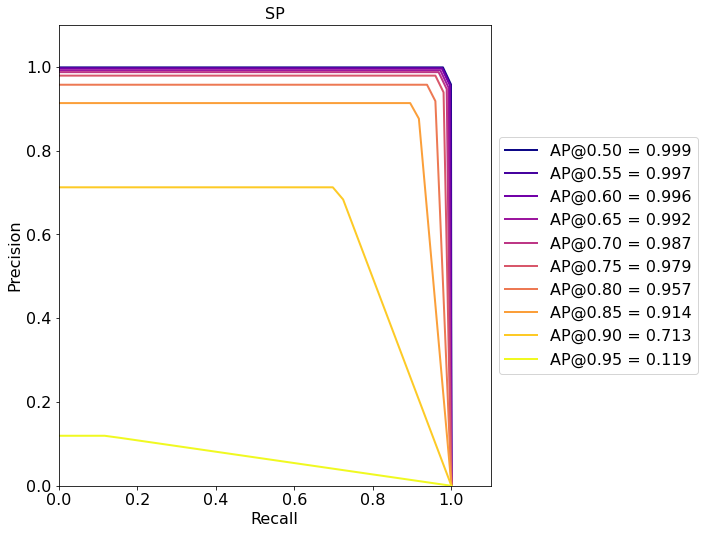

In [13]:
mean_APs_frb = []
mean_ps_frb  = []
mean_rs_frb  = []

iou_thresholds = np.arange(0.5,1.0,0.05)

for i in iou_thresholds:
    
    APs, ps, rs = compute_performance(dataset,model,config,i)
    mean_APs_frb.append(APs)
    mean_ps_frb.append(ps)
    mean_rs_frb.append(rs)
    
plot_precision_recall_range(mean_APs_frb,iou_thresholds,mean_ps_frb,mean_rs_frb,\
    save_fig=True,title='SP',filename='SP_test')

## Calculate metrics on Validation set

In [15]:
prediction_file = pd.read_csv('./results/prediction_validation.csv')

ytrue       = prediction_file['y_true']
ypred       = prediction_file['y_predict']
accuracy    = balanced_accuracy_score(ytrue,ypred)
conf_matrix = confusion_matrix(ytrue,ypred)
mcc         = matthews_corrcoef(ytrue,ypred)


metrics_file = open('./results/metrics.txt','w')
metrics_file.write('Accuracy = %f' %float(accuracy) + '\n')
metrics_file.write('Mathew correlation coefficient = %f' %float(mcc) + '\n')
metrics_file.write('='*80+'\n')
metrics_file.write(classification_report(ytrue,ypred,labels=[1,2]) )
metrics_file.write('='*80+'\n\n')


print(balanced_accuracy_score(ytrue,ypred))
print(confusion_matrix(ytrue,ypred))
print(matthews_corrcoef(ytrue,ypred))
print(classification_report(ytrue,ypred,labels=[1,2]))

1.0
[[3357]]
0.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3357
           2       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00      3357
   macro avg       0.50      0.50      0.50      3357
weighted avg       1.00      1.00      1.00      3357



# Prediction on test set
### Find the brightest pixel of the candidates after prediction using the generated mask from the prediction

In [16]:
def horizontal_flip(image_array):
    return image_array[:, ::-1]

In [17]:
# This function takes the mask obtained during prediction and crops it from the original image
def crop_mask_from_original_im(image, mask):
    """Apply the given mask to the image.
    """
    background = np.zeros((256,256))
    image[:, :] = np.where(mask == 1,image[:, :],background[:,:])
    return image

In [18]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha *color[c] * 255,
                                  image[:, :, c])
    return image

In [19]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [ ]:
test_dir = './automated_mask_code/fetch_data/val/*.h5' # For FRB text data
test_files  =glob.glob(test_dir)
#test_files = test_files[10:20]

final_table = pd.DataFrame()
for i in range(len(test_files)):
    filename   = os.path.basename(test_files[i])
    with h5py.File(test_files[i],'r') as f:
        image_ = np.array(f["data_dm_time"]).astype('float32')
        true_DM= f.attrs['dm']
        tstart = f.attrs['tstart']*10**3 # in ms
        tsamp  = f.attrs['tsamp']*10**3 # in ms
        nchans = f.attrs['nchans']
        plt.imsave('./images/'+filename+'.jpg',image_,cmap=plt.cm.jet)        
        image = skimage.io.imread('./images/'+filename+'.jpg')
        print(image_.max())
                
        test_results = model.detect([image], verbose=1)
        r            = test_results[0]
        masks = r['masks']
        boxes = r['rois']
        class_ids = r['class_ids']
        scores = r['scores']
        class_names = dataset.class_names
        
        # Number of instances
        N = boxes.shape[0]
        if not N:
            print("\n*** No instances to display *** \n")
        else:
            assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

        # If no axis is passed, create one and automatically call show()
        auto_show = False; ax = None; colors=None; figsize=(15,15); show_mask=True;
        show_bbox=True;captions=None; title=str(filename)
        
       # If no axis is passed, create one and automatically call show()
        auto_show = False
        if not ax:
            _, ax = plt.subplots(1, figsize=figsize)
            auto_show = True

        # Generate random colors
        colors = colors or random_colors(N)

        # Show area outside image boundaries.
        height, width = image.shape[:2]
        ax.set_ylim(height + 10, -10)
        ax.set_xlim(-10, width + 10)
        ax.axis('off')
        ax.set_title(title,fontsize=25)
        
        masked_image = image.astype(np.uint32).copy()
        for i in range(N):
            color = colors[i]

            # Bounding box
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in image cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            if show_bbox:
                p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                    alpha=0.7, linestyle="dashed",
                                    edgecolor=color, facecolor='none')
                ax.add_patch(p)

            # Label
            if not captions:
                class_id = class_ids[i]
                score = scores[i] if scores is not None else None
                label = class_names[class_id]
                caption = "{} {:.3f}".format(label, score) if score else label
            else:
                caption = captions[i]
            ax.text(x1, y1 + 8, caption,
                    color='w', size=25, backgroundcolor="none")

            # Mask
            mask = masks[:, :, i]
            if show_mask:
                masked_image = apply_mask(masked_image, mask,color)
                
            masked_image_ori = crop_mask_from_original_im(image_, mask)
            # find the brightest pixel
            position_int_max = np.unravel_index(masked_image_ori.argmax(),masked_image_ori.shape)
            print('The brightest pixel is {:.3f} at position {}'.format(masked_image_ori[position_int_max],position_int_max))
            
            position_dm = position_int_max[0];position_time=position_int_max[1]
            calculated_dm = (true_DM*256)/(2*position_dm)
            #calculated_dm = ((2*true_DM)/256)*position_dm

            uncertainty_dm = ((2*true_DM)/256)*2
            calculated_tim = tstart + (tsamp*position_time)
            print('The true DM is {:.3f}'.format(true_DM))
            print('The calculated DM detected from prediction is {:.3f} at time {:.3f}'.format(calculated_dm,calculated_tim))    
                
            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
                
        results = pd.DataFrame()
        results['filename']    = np.array(filename).reshape(1,)
        results['y_true']      = 1
        results['y_predict']   = class_names[class_id]
        results['probability_FRB'] = scores[0]
        results['true_DM'] = true_DM
        results['calculated_DM'] = calculated_dm
        results['err_calculated_DM'] = uncertainty_dm
        final_table                     = final_table.append(results)

                
        ax.imshow(masked_image)
        ax.text(270,10, 'Detected Class:'+str(class_names[class_id]), fontsize=25)
        ax.text(270,20, 'Probability FRB: {:.3f}'.format(scores[0]), fontsize=25)
        ax.text(270,30, 'Calculated DM: {:.3f} ± {:.3f}'.format(calculated_dm, uncertainty_dm), fontsize=25)
        ax.text(270,40, 'Calculated time: {:.3f}'.format(calculated_tim), fontsize=25)
        ax.text(270,50, 'Brightest Pixel: {:.3f}'.format(masked_image_ori[position_int_max]), fontsize=25)
        ax.text(270,60, 'Brightest Pixel at position:'+str(position_int_max), fontsize=25)
        plt.savefig('./results/predicted_images/'+filename[:-3]+'.jpg',bbox_inches='tight',pas_inches=0.1)
final_table.to_csv('./results/prediction_test_set.csv',index=None)       

# Make videos

In [ ]:

img_array = []
for filename in glob.glob('./results/predicted_images/*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('./results/prediction.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 1, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()